In [14]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

base_path = Path(r"I:\Dokumente\Bachelor Thesis\Thesis\Simulator\Datasets\Smart meters in London")

### Acorn Lookup

In [12]:
path_acorn_csv = base_path / 'data' / 'informations_households.csv'
assert path_acorn_csv.exists(), f"File not found: {path_acorn_csv}"

lookup_dict = {}
lookup_df = pd.read_csv(path_acorn_csv)

# Drop all rows with Acorn not in [ACORN-A, ... , ACORN-V]
lookup_df = lookup_df[lookup_df['Acorn'].str.match(r'ACORN-[A-Z]')]
lookup_df = lookup_df[['LCLid', 'Acorn', 'Acorn_grouped']]

In [49]:
# What we want:
# A list of shape LCLid, date, 00:00, 00:30, 01:00, 01:30, ..., 23:30
# Where the values are the energy consumption for that half hour

# What we have:
# A list of shape LCLid, timestamp, energy consumption
# Where the timestamp is in the format YYYY-MM-DD HH:MM:SS.0000000

data = {}

# LCLid,tstp,energy(kWh/hh)
# MAC000026,2011-12-07 11:00:00.0000000, 0.611 
for i in range(0,20):
    # Try to read all to see if there are any errors
    print(f'block_{i}.csv')
    df = pd.read_csv(
        f'data/block_{i}.csv', 
        dtype={'LCLid': 'str', 'tstp': 'str', 'energy(kWh/hh)': 'float'}, 
        on_bad_lines='warn',
        na_values=['Null']
    )
    df['LCLid'] = df['LCLid'].astype('str')
    df['tstp'] = pd.to_datetime(df['tstp'], format='%Y-%m-%d %H:%M:%S.%f')
    
    df.dropna(inplace=True)
    
    df['date'] = df['tstp'].dt.date
    df['time'] = df['tstp'].dt.time
    df.drop(columns=['tstp'], inplace=True)
    
    df['energy'] = df['energy(kWh/hh)'].astype('float')
    df.drop(columns=['energy(kWh/hh)'], inplace=True)
    
    df['energy'] = df['energy'] * 1000 # Convert to Wh
    df['energy'] = df['energy'].astype('int')
    
    for id, date, time, energy in df.values:
        if id not in data:
            data[id] = {}
        if date not in data[id]:
            data[id][date] = {}
        data[id][date][time] = energy

rows = []
for id, dates in data.items():
    for date, times in dates.items():
        readings = [list() for _ in range(24)]
        for time, energy in times.items():
            hour = time.hour
            readings[hour].append(energy)
        if any(len(r) == 0 for r in readings):
            print(f'Error in {id} {date}', readings)
            continue
        for i in range(24):
            if len(readings[i]) == 1:
                readings[i] = readings[i] + readings[i]
        row = [id, date] + [sum(r) for r in readings]
        rows.append(row)
print(f'Writing {len(rows)} rows')
headers=['LCLid', 'date'] + [f'{i:02}:00' for i in range(0,24)]
out_df = pd.DataFrame(rows, columns=headers)

# Keep at most 5 entries per LCLid
# out_df = out_df.groupby('LCLid').sample(5)

out_df.shape
out_df.to_csv('data/processed.csv', index=False)

block_0.csv
block_1.csv
block_2.csv
block_3.csv
block_4.csv
block_5.csv
block_6.csv
block_7.csv
block_8.csv
block_9.csv
block_10.csv
block_11.csv
block_12.csv
block_13.csv
block_14.csv
block_15.csv
block_16.csv
block_17.csv
block_18.csv
block_19.csv
Error in MAC000002 2012-11-08 [[186], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
Error in MAC000002 2014-02-28 [[1387], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
Error in MAC000246 2011-12-03 [[], [], [], [], [], [], [], [], [], [149, 154], [768, 1179], [588, 144], [843, 752], [120, 90], [53, 53], [47, 50], [63, 69], [110, 70], [76, 76], [63, 95], [52, 49], [205, 229], [368, 295], [1125, 1072]]
Error in MAC000246 2014-02-28 [[145], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
Error in MAC000450 2012-03-22 [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1365], [1274, 817], [678, 748],

(625517, 26)

In [60]:
# Look at how many entries we have for each date
step = out_df.groupby('date').size()
# Filter out dates with less than 100 entries
step = step[step > 100]
# Pick a random date from that list
date = step.sample(1).index[0]
# Filter out all entries that are not from that date
out_df[out_df['date'] == date]

,LCLid,date,00:00,01:00,02:00,03:00,04:00,05:00,06:00,07:00,...,14:00,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00
30,MAC000002,2012-11-12,497,483,303,206,204,207,220,217,...,1433,209,267,781,586,638,1059,540,528,522
847,MAC000246,2012-11-12,2348,1798,1371,137,127,149,191,1014,...,190,161,185,167,333,320,1012,798,1629,2138
1553,MAC000450,2012-11-12,3134,1928,1857,1830,1834,2338,2397,3118,...,4294,5313,5816,6926,7175,5188,5700,6368,3743,3021
1923,MAC001074,2012-11-12,2530,496,497,423,381,407,525,753,...,2531,972,783,1260,3263,3580,1231,660,2439,1389
2016,MAC003223,2012-11-12,470,176,111,110,91,232,97,1137,...,730,1877,1832,658,874,945,810,901,1084,861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622236,MAC005440,2012-11-12,95,90,78,41,68,82,48,51,...,1041,1002,1084,840,253,89,868,945,865,677
622916,MAC005442,2012-11-12,3033,1858,1796,1255,1372,1436,1398,1305,...,2067,1900,1743,1922,2105,1811,1622,1678,1742,1895
623596,MAC005553,2012-11-12,533,403,512,614,665,940,988,1320,...,2936,1972,3117,4179,2811,2656,2647,2274,1586,683
624243,MAC005554,2012-11-12,188,123,142,147,141,141,144,178,...,107,132,85,366,461,585,473,212,110,148


In [13]:
day_df = pd.read_csv('data/processed.csv')
value_columns = [f'{i:02}:00' for i in range(0,24)]
# Add column for max min sum and mean
day_df['max'] = day_df[value_columns].max(axis=1)
day_df['min'] = day_df[value_columns].min(axis=1)
day_df['sum'] = day_df[value_columns].sum(axis=1)
day_df['mean'] = day_df[value_columns].mean(axis=1)
# Group by LCLid merge the columns
day_df = day_df.groupby('LCLid').agg({
    'max': 'max',
    'min': 'min',
    'sum': 'mean',
    'mean': 'mean'
})

# Merge with lookup_df on LCLid
day_df = day_df.merge(lookup_df, on='LCLid')
day_df.head()

,LCLid,max,min,sum,mean,Acorn,Acorn_grouped
0,MAC000002,4586,0,12119.389662,504.974569,ACORN-A,Affluent
1,MAC000005,3119,20,4580.160630,190.840026,ACORN-C,Affluent
2,MAC000015,5134,115,10989.901235,457.912551,ACORN-E,Affluent
3,MAC000017,4093,44,6383.592138,265.983006,ACORN-C,Affluent
4,MAC000026,5042,171,12454.768473,518.948686,ACORN-D,Affluent


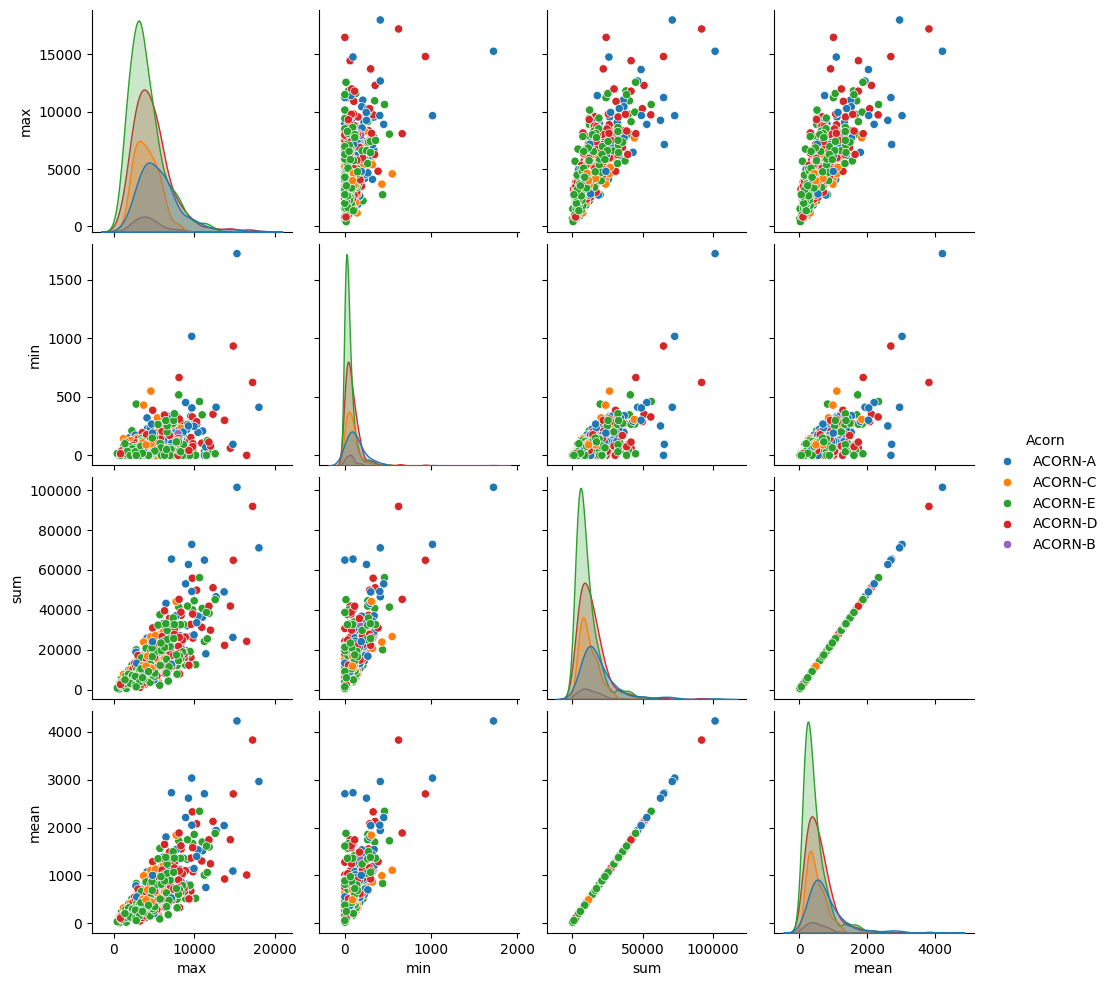

In [16]:
sns.pairplot(day_df, hue='Acorn')